# Import packages, data and define useful functions

In [1]:
# Import all important packages and set parameters
from __future__ import division
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14
import torch
import torch.nn as nn
import numpy as np
from math import pi 
import seaborn as sns
import pandas as pd
import corner
import emcee
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.model_selection import train_test_split

from utils import *

In [2]:
# Fixing seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)

In [3]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
print('Pytorch version:',torch.__version__)
if torch.cuda.is_available() is True:
    print(f'Device type: {torch.cuda.get_device_name(0)}')

Device: cpu
Pytorch version: 2.1.0+cpu


In [4]:
# Define polynomial model
def polynomial_model(eval_arr, a4, a3, a2, a1, a0, noise):
    '''
    Calculates f(x) values, if f(x) is a polynomial model with parameters params_arr; x is eval_arr
    '''
    output = a4*eval_arr**4 + a3*eval_arr**3 + a2*eval_arr**2 + a1*eval_arr**1 + a0*eval_arr**0 + np.random.normal(0, noise, size=eval_arr.shape[0])
    return output

# Create neccessary datasets

In [5]:
# Dictionary to save important information
class dictionary(dict): 
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [6]:
# Instantiate params dictionary
settings = dictionary()

In [7]:
# Sample polynomial parameters
settings.samp_data = 15
a4 = np.random.uniform(-1, 1, settings.samp_data)
a3 = np.random.uniform(-2, 2, settings.samp_data)
a2 = np.random.uniform(-3, 3, settings.samp_data)
a1 = np.random.uniform(-10, 10, settings.samp_data) 
a0 = np.random.uniform(-20, 20, settings.samp_data)
u = np.linspace(-5, 5, 20) # Evaluation points of the polynomial  f(u) = a4*x^4 + a3*x^3 + a2*x^2 + a1*x + a0
noise = 2 # Try 0.5

# Calculate dataset containing lines of linear functions and associated parameters
function_points = np.zeros((a0.shape[0]*a1.shape[0]*a2.shape[0]*a3.shape[0]*a4.shape[0], u.shape[0]), dtype=np.float32)
param_values = np.zeros((a0.shape[0]*a1.shape[0]*a2.shape[0]*a3.shape[0]*a4.shape[0], 5), dtype=np.float32)
cont = 0
for i_a4 in a4:
    for i_a3 in a3:
        for i_a2 in a2:
            for i_a1 in a1:
                for i_a0 in a0:
                    function_points[cont,:] = polynomial_model(u, i_a4, i_a3, i_a2, i_a1, i_a0, noise)
                    param_values[cont,0] = i_a4; param_values[cont,1] = i_a3; param_values[cont,2] = i_a2; param_values[cont,3] = i_a1; param_values[cont,4] = i_a0
                    cont = cont + 1

# Print shapes of lines and values
print('Shape of function lines set:', function_points.shape)
print('Shape of parameter set:', param_values.shape)

Shape of function lines set: (759375, 20)
Shape of parameter set: (759375, 5)


In [8]:
# Define input x and context y
x = param_values # input 
y = function_points # context

# Make training and testing splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardize the input x and context y for training dataset
x_scaler_train = StandardScaler().fit(x_train)
y_scaler_train = StandardScaler().fit(y_train)
x_std_train = x_scaler_train.transform(x_train)
y_std_train = y_scaler_train.transform(y_train)

# Standardize the input x and context y for testing dataset
x_scaler_test = StandardScaler().fit(x_test)
y_scaler_test = StandardScaler().fit(y_test)
x_std_test = x_scaler_test.transform(x_test)
y_std_test = y_scaler_test.transform(y_test)

# Define base distribution z, such that z = f(x) for training dataset
z_train = MultivariateNormal(torch.zeros(x_std_train.shape[1]), torch.eye(x_std_train.shape[1])).rsample(sample_shape=(x_std_train.shape[0],)).detach().numpy()

# Define base distribution z, such that z = f(x) for testing dataset
z_test = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(x_std_test.shape[0],)).detach().numpy()

# Print shapes of training data
print(f'Input x_std_train shape: {x_std_train.shape}')
print(f'Context y_std_train shape: {y_std_train.shape}')
print(f'Output z_train shape: {z_train.shape}')

# Print shapes of testing data
print(f'Input x_std_test shape: {x_std_test.shape}')
print(f'Context y_std_test shape: {y_std_test.shape}')
print(f'Output z_test shape: {z_test.shape}')

Input x_std_train shape: (607500, 5)
Context y_std_train shape: (607500, 20)
Output z_train shape: (607500, 5)
Input x_std_test shape: (151875, 5)
Context y_std_test shape: (151875, 20)
Output z_test shape: (151875, 5)


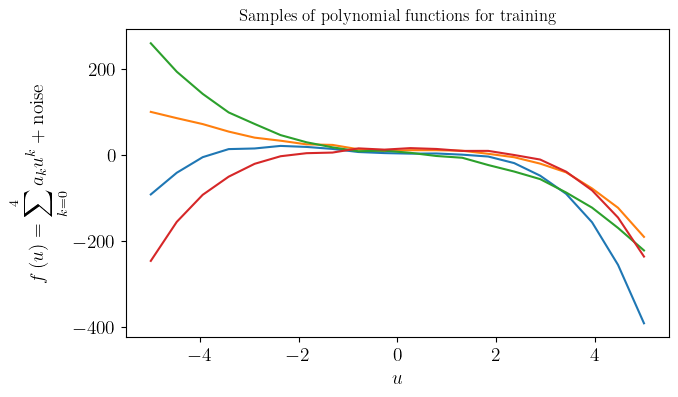

In [9]:
# Plot samples of lines and values (target distribution)
plt.figure(figsize=(7,4))
plt.title('Samples of polynomial functions for training', fontsize=12)
plt.xlabel('$u$')
plt.ylabel('$$f\,(u) = \sum_{k=0}^{4} a_ku^k + \\text{noise}$$')
i = 0
while i < 4:
    randN = np.random.randint(0, x_train.shape[0])
    plt.plot(u, y_train[randN, :])
    i = i + 1
plt.savefig('nf-polynomial-regression-example-linesamples.pdf')

In [10]:
# Define labels for input vector x
labels = ['$a_4$', '$a_3$', '$a_2$', '$a_1$', '$a_0$']

# Define coupling layer and normalizing flow

In [11]:
# Define coupling layer (affine coupling type)
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size, context_size=None):
        """
        Initializes the coupling layer.

        input_size: Size (dimension) of the input, which is to be transformed to a base distribution (standard normal distribution).
        hidden_size: Size (dimension) of the hidden layers of the neural networks involved in the transformations.
        """
        # Initialize object
        super().__init__()

        # Assign variables to coupling layer input
        self.D, self.d, self.m, self.h = context_size, input_size, int(input_size/2), hidden_size

        # Decide on size of neural network input
        if context_size is not None:
            self.net_in = self.m + self.D
        else:
            self.net_in = self.m

        # Define neural network implementing the shift parameter mu of an affine function: f(x) = sig*x + mu
        self.sig_net = nn.Sequential(
                    nn.Linear(self.net_in, self.h),
                    nn.LeakyReLU(),
                    nn.Linear(self.h, (self.d-self.m)))

        # Define neural network implementing the scale parameter sigma of an affine function: f(x) = sig*x + mu
        self.mu_net = nn.Sequential(
                    nn.Linear(self.net_in, self.h),
                    nn.LeakyReLU(),
                    nn.Linear(self.h, (self.d-self.m)))

    def forward(self, x, context=None, flip=False, inverse=False):
        """
        Defines the forward and inverse direction of the coupling layer.

        x: Input, which is to be transformed to a base distribution (standard normal distribution).
        context: Context, on which the input data is conditioned.
        flip: Default is False; if True, input is split into two and flipped after every coupling layer.
        inverse: Default is False; if True, the inverse direction of the normalizing flow is active.
        """
        # Split input into two parts
        x1, x2 = torch.split(x, [self.m, self.d - self.m], dim=1)

        # Flip the two parts, if flip is True
        if flip:
            x1, x2 = torch.split(x, [self.d - self.m, self.m], dim=1)
            x2, x1 = x1, x2

        # If there is context, concatenate it with one part of the input to feed to the neural networks
        if context is not None:
            xy = torch.cat([x1, context], dim=-1)
        else:
            xy = x1

        # Instantiate and calculate neural networks for the scale and shift parameters sig and mu
        mu = self.mu_net(xy)
        sig = self.sig_net(xy)

        # Calculate forward transformation, if inverse=False
        if not inverse:
            z1, z2 = x1, mu + x2 * torch.exp(sig)

        # Calculate inverse transformation, if inverse=True
        else:
            z1, z2 = x1, (x2 - mu) * torch.exp(-sig)

        # Again flip the data, if flip is True
        if flip:
            z2, z1 = z1, z2 

        # Concatenate unprocessed and processed input to an output tensor
        z = torch.cat([z1, z2], dim=-1)

        # Calculate log-likelihood
        pz = MultivariateNormal(torch.zeros(x.shape[1]), torch.eye(x.shape[1]))
        log_pz = pz.log_prob(z)
 
        # Calculate determinant of log-likelihood
        log_det_J = sig.sum(-1)

        # Return output tensor, log-likelihood and determinant of log-likelihood
        return z, log_pz, log_det_J

In [12]:
# Define normalizing flow (RNVP type)
class NormalizingFlow(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, context_size=None):
        """
        Initializes the normalizing flow architecture

        input_size: Size (dimension) of the input, which is to be transformed to a base distribution (standard normal distribution).
        hidden_size: Size (dimension) of the context, on which the input data is conditioned.
        num_layers: Integer defining the total coupling layer number of the normalizing flow.
        context_size: Size (dimension) of the context, on which the input is conditioned.
        """
        # Initialized object
        super().__init__()

        # Create a list of coupling layers with specified characteristics
        self.bijectors = nn.ModuleList([
            CouplingLayer(input_size, hidden_size, context_size) for _ in range(num_layers)
        ])

        # Create a list of alternating flip values for all coupling layers of the transformation
        self.flips = [True if i%2 else False for i in range(num_layers)]
        
    def forward(self, x, context=None, inverse=False):
        """
        Defines the forward and inverse direction of the normalizing flow

        x: Input, which is to be transformed to a base distribution (standard normal distribution).
        context: Context, on which the input data is conditioned.
        flip: Default is False; if True, input is split into two and flipped after every coupling layer.
        inverse: Default is False; if True, the inverse direction of the normalizing flow is active.
        """
        # Define empty list to store log-likelihoods and determinants of log-likelihoods
        lg_pz = []
        lg_det_J = []

        # Calculate resulting log-likelihoods and determinants thereof in forward direction
        if not inverse:
            for biijector, f in zip(self.bijectors, self.flips):
                x, lpz, ldj = biijector(x, context=context, inverse=False, flip=f)
                lg_pz.append(lpz)
                lg_det_J.append(ldj)

        # Calculate resulting log-likelihoods and determinants thereof in inverse direction
        else:
            for biijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
                x, lpz, ldj = biijector(x, context=context, inverse=True, flip=f)
                lg_pz.append(lpz)
                lg_det_J.append(ldj)
                
        # Return processed input, the total log-likelihood and the determinant of the total log-likelihood
        return x, sum(lg_pz), sum(lg_det_J)

# Define loss function and dataloader

## Define loss function

In [13]:
# Define loss function
def loss_function(model, input, context=None):
    """
    Calculates the loss for training a normalizing flow.

    model: Normalizing flow model.
    x: Input, which is to be transformed to a base distribution (standard normal distribution).
    context: Context, on which the input data is conditioned.
    """
    # Calculate processed input (output), total log-likelihood and determinant of total log-likelihood
    z, log_pz, log_det_J = model(input, context=context, inverse=False)

    # Calculate and return loss as given by the change of variable theorem of probability theory
    loss = -torch.mean(log_pz + log_det_J)
    return loss

## Define dataloader

In [14]:
# Convert training data to PyTorch tensors
x_std_train = torch.tensor(x_std_train, dtype=torch.float32) # Make input x to tensor
y_std_train = torch.tensor(y_std_train, dtype=torch.float32) # Make context y to tensor
z_train = torch.tensor(z_train, dtype=torch.float32) # Make target distribution to tensor

# Convert testing data to PyTorch tensors
x_std_test = torch.tensor(x_std_test, dtype=torch.float32) # Make input x to tensor
y_std_test = torch.tensor(y_std_test, dtype=torch.float32) # Make context y to tensor
z_test = torch.tensor(z_test, dtype=torch.float32) # Make target distribution to tensor

In [15]:
# Print sizes of training data
print(f'Size of x_std_train: {x_std_train.size()}')
print(f'Size of y_std_train: {y_std_train.size()}')
print(f'Size of z_train: {z_train.size()}')

# Print sizes of testing data
print(f'Size of x_std_test: {x_std_test.size()}')
print(f'Size of y_std_test: {y_std_test.size()}')
print(f'Size of z_test: {z_test.size()}')

Size of x_std_train: torch.Size([607500, 5])
Size of y_std_train: torch.Size([607500, 20])
Size of z_train: torch.Size([607500, 5])
Size of x_std_test: torch.Size([151875, 5])
Size of y_std_test: torch.Size([151875, 20])
Size of z_test: torch.Size([151875, 5])


In [16]:
# Define dataloader for training
settings.batch_size = 512
dataset_train = torch.utils.data.TensorDataset(x_std_train, y_std_train) # Input: x, context: y
dataset_test = torch.utils.data.TensorDataset(x_std_test, y_std_test) # Input: x, context: y
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

# Instantiate normalizing flow and training settings

In [17]:
# Settings for model
settings.input_size = np.array(x_std_train).shape[1]
settings.context_size = np.array(y_std_train).shape[1]
settings.hidden_size = 32 # 128
settings.num_layers = 7 # 8

# Instantiate the normalizing flow
normalizing_flow_pol_regr = NormalizingFlow(settings.input_size, settings.hidden_size, settings.num_layers, context_size=settings.context_size)

In [18]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 8

# Define optimizer and scheduler
optimizer = torch.optim.Adam(normalizing_flow_pol_regr.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, settings.scheduling_rate)

# Train the flow

In [19]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x, batch_y in dataloader_train:
        normalizing_flow_pol_regr.train()
        optimizer.zero_grad()
        loss = loss_function(normalizing_flow_pol_regr, batch_x, context=batch_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x, batch_y in dataloader_test:
        normalizing_flow_pol_regr.eval()
        loss = loss_function(normalizing_flow_pol_regr, batch_x, context=batch_y)
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 1 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))
        print('Epoch {}/{} test loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_test_loss))

Epoch 1/8 train loss: 0.0484
Epoch 1/8 test loss: 0.0429
Epoch 2/8 train loss: 0.0420
Epoch 2/8 test loss: 0.0415
Epoch 3/8 train loss: 0.0412
Epoch 3/8 test loss: 0.0410
Epoch 4/8 train loss: 0.0409
Epoch 4/8 test loss: 0.0409
Epoch 5/8 train loss: 0.0408
Epoch 5/8 test loss: 0.0409
Epoch 6/8 train loss: 0.0408
Epoch 6/8 test loss: 0.0409
Epoch 7/8 train loss: 0.0408
Epoch 7/8 test loss: 0.0409
Epoch 8/8 train loss: 0.0408
Epoch 8/8 test loss: 0.0409


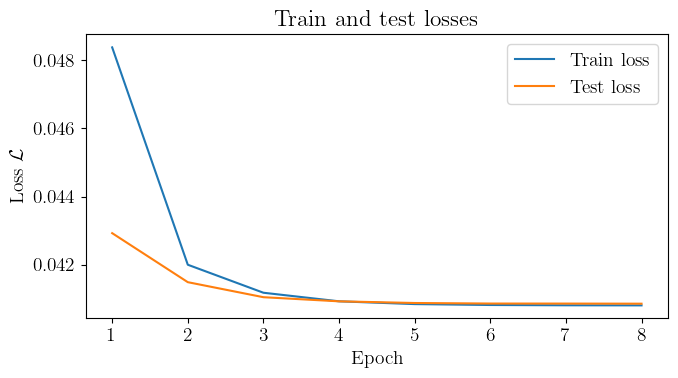

In [20]:
# Print train and test losses
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/settings.num_epochs)
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-polynomial-regression-example-loss.pdf')

# Test the flow
The values of parameters $\boldsymbol{x} = (a_4, a_3, a_2, a_1, a_0)^\top$ must fulfill $$-1 \leq a_4 \leq 1, \, -2 \leq a_3 \leq 2,\, -3 \leq a_2 \leq 3,\, -10 \leq a_1 \leq 10,\, -20 \leq a_0 \leq 20, $$
because the normalizing flow was trained on samples generated by these restrictions.

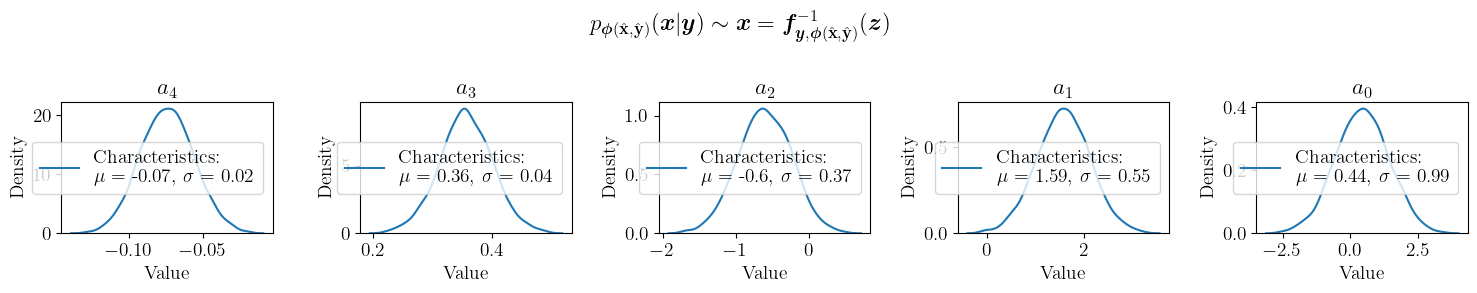

In [21]:
# Generate a test sample
settings.probe_samples = 5000
probeval = np.array([-0.06, 0.32, -1.1, 2.3, 1.6])
probeobs = polynomial_model(u, probeval[0], probeval[1], probeval[2], probeval[3], probeval[4], 2*noise)
z_probe = MultivariateNormal(torch.zeros(5), torch.eye(5)).rsample(sample_shape=(settings.probe_samples,))
y_probe = torch.tensor(np.repeat(probeobs[None,:], z_probe.shape[0], axis=0))
y_probe_std = torch.tensor(y_scaler_test.transform(y_probe), dtype=torch.float32)

# Propagate it through the inverse normalizing flow
x_probe_std, _, _ = normalizing_flow_pol_regr(z_probe, context=y_probe_std, inverse=True)
x_probe_std = x_probe_std.detach().numpy()
x_probe_nf = x_scaler_test.inverse_transform(x_probe_std)

# Plot results
plot_dens(x_probe_nf, x_probe_nf.shape[1], inp_names=labels, title='$p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = \\bm{f}^{-1}_{\\bm{y},\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{z})$', savename='nf-polynomial-regression-example-calctargetdensities.pdf')

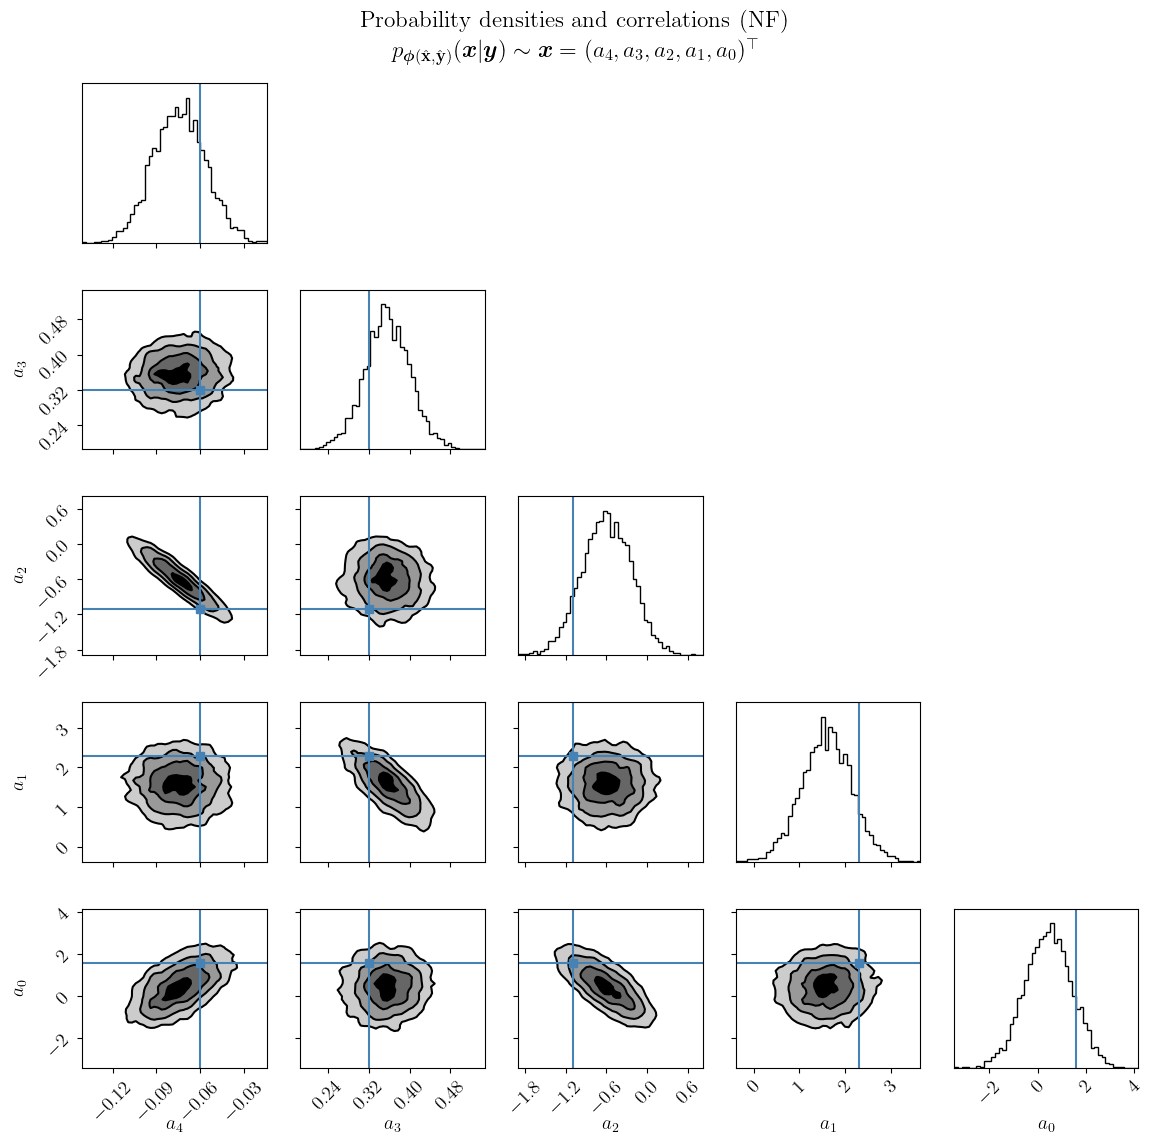

In [44]:
# Produce corner plot
figure = corner.corner(x_probe_nf, labels=labels, truths=probeval, show_titles=False, plot_datapoints=False, bins=50, fill_contours=True, smooth=1.0)
plt.suptitle('Probability densities and correlations (NF)\n$p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (a_4, a_3, a_2, a_1, a_0)^\\top$')
plt.tight_layout()
plt.savefig('nf-polynomial-regression-example-corner.pdf')

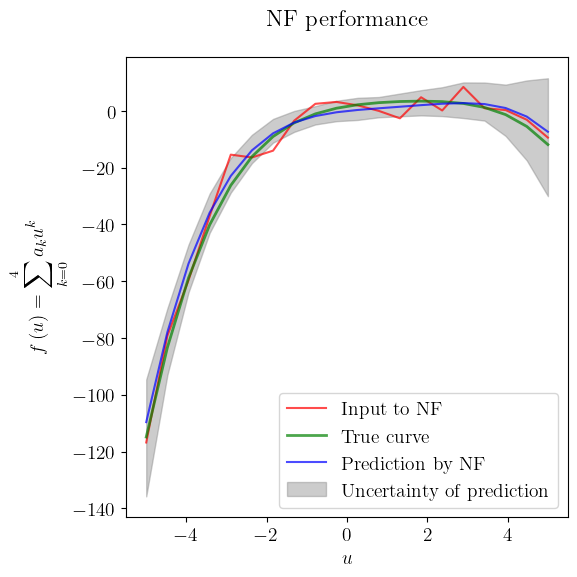

In [32]:
# Extract maximum and minimum values for each point u on the horizontal axis
likeliest_line_nf, max_line_nf, min_line_nf = find_boundaries_polynomial(x_probe_nf, u)

# Visualize results of the normalizing flow
plt.figure(figsize=(6,6))
plt.title('NF performance\n')
plt.plot(u, probeobs, color='red', label='Input to NF', alpha=0.7)
plt.plot(u, probeval[0]*u**4 + probeval[1]*u**3 + probeval[2]*u**2 + probeval[3]*u + probeval[4], color='green', label='True curve', alpha=0.7, linewidth=2)
plt.plot(u, likeliest_line_nf, color='Blue', label='Prediction by NF', alpha=0.7)
plt.fill_between(u, min_line_nf, max_line_nf, color='Grey', alpha=0.4, label='Uncertainty of prediction')
plt.legend(loc='best')
plt.xlabel('$u$')
plt.ylabel('$$f\,(u) = \sum_{k=0}^{4} a_ku^k$$')
plt.tight_layout()
plt.savefig('nf-polynomial-regression-example-nfperformance.pdf')

In [33]:
# Print settings for training and testing
for key, value in settings.items():
    print(key, ' : ', value)

samp_data  :  15
batch_size  :  512
input_size  :  5
context_size  :  20
hidden_size  :  32
num_layers  :  7
learning_rate  :  0.001
scheduling_rate  :  0.999
num_epochs  :  8
probe_samples  :  5000


# Compare normalizing flow results with MCMC method

In [25]:
# Define functions to calculate posterior density p(params|curves), where params are the parameters and curves the values of a polynomial model curves = M(params)
def model(params, x):
    # Returns curves = M(params)
    return params[0]*x**4 + params[1]*x**3 + params[2]*x**2 + params[3]*x**1 + params[4]*x**1

def log_likelihood(params, x, y, noise):
    model_y = model(params, x)
    return -0.5*np.sum((y - model_y)**2/noise**2)

def log_prior(params):
    if -1 < params[0] < 1 and -2 < params[1] < 2 and -3 < params[2] < 3 and -10 < params[3] < 10 and -20 < params[4] < 20:
        return 0.0
    return -np.inf

def log_posterior(params, x, y, noise):
    lg_prior = log_prior(params)
    if not np.isfinite(lg_prior):
        return -np.inf
    return lg_prior + log_likelihood(params, x, y, noise)

In [26]:
# Define data for MCMC sampling
X = np.copy(u)
Y = np.copy(probeobs)

# Define noise for MCMC sampling
MCMC_noise = np.ones(Y.shape[0], dtype=np.float32)*noise

# Define parameters and initial value for MCMC sampling
nwalkers = 50
ndim = 5
nsteps = 5000
p0 = np.random.rand(nwalkers, ndim)

# Do sampling
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(X, Y, MCMC_noise))
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract samples from the sampler
x_probe_mcmc = sampler.get_chain(discard=1000, flat=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:10<00:00, 463.89it/s]


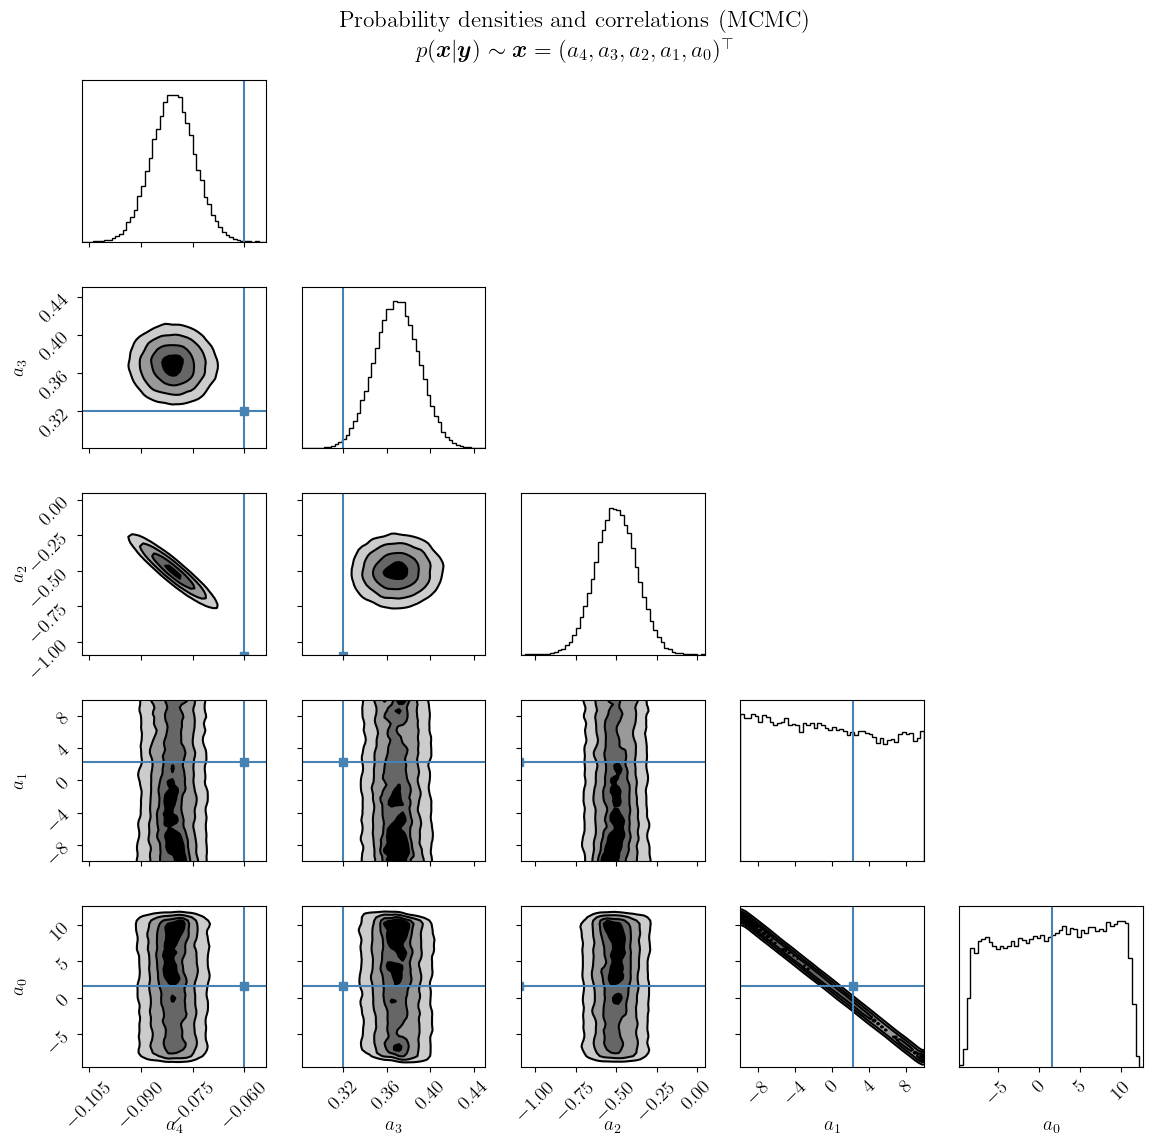

In [45]:
# Make corner plot
figure = corner.corner(x_probe_mcmc, labels=labels, truths=probeval, show_titles=False, plot_datapoints=False, bins=50, fill_contours=True, smooth=1.0)
plt.suptitle('Probability densities and correlations (MCMC)\n$p(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (a_4, a_3, a_2, a_1, a_0)^\\top$')
plt.tight_layout()
plt.savefig('nf-polynomial-regression-example-corner-mcmc.pdf')

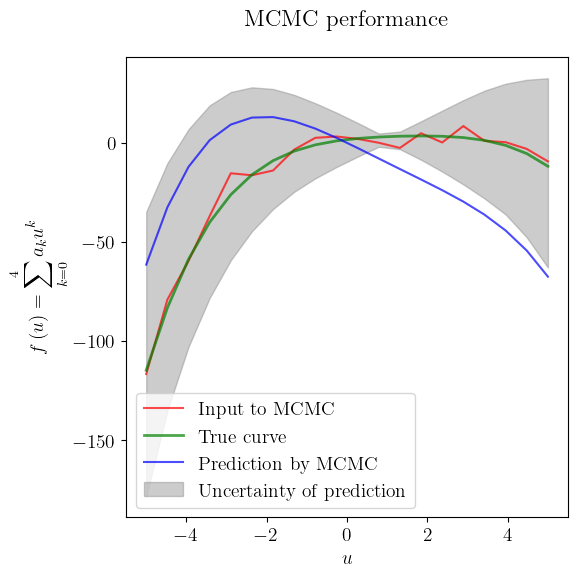

In [35]:
# Extract maximum and minimum values for each point u on the horizontal axis
likeliest_line_mcmc, max_line_mcmc, min_line_mcmc = find_boundaries_polynomial(x_probe_mcmc, u)

# Visualize results of the normalizing flow
plt.figure(figsize=(6,6))
plt.title('MCMC performance\n')
plt.plot(u, probeobs, color='red', label='Input to MCMC', alpha=0.7)
plt.plot(u, probeval[0]*u**4 + probeval[1]*u**3 + probeval[2]*u**2 + probeval[3]*u + probeval[4], color='green', label='True curve', alpha=0.7, linewidth=2)
plt.plot(u, likeliest_line_mcmc, color='Blue', label='Prediction by MCMC', alpha=0.7)
plt.fill_between(u, min_line_mcmc, max_line_mcmc, color='Grey', alpha=0.4, label='Uncertainty of prediction')
plt.legend(loc='best')
plt.xlabel('$u$')
plt.ylabel('$$f\,(u) = \sum_{k=0}^{4} a_ku^k$$')
plt.tight_layout()
plt.savefig('nf-polynomial-regression-example-mcmcperformance.pdf')

In [29]:
# Calculate weights
weights_nf = np.ones_like(x_probe_nf[:,0])/len(x_probe_nf[:,0])
weights_mcmc = np.ones_like(x_probe_mcmc[:,0])/len(x_probe_mcmc[:,0])

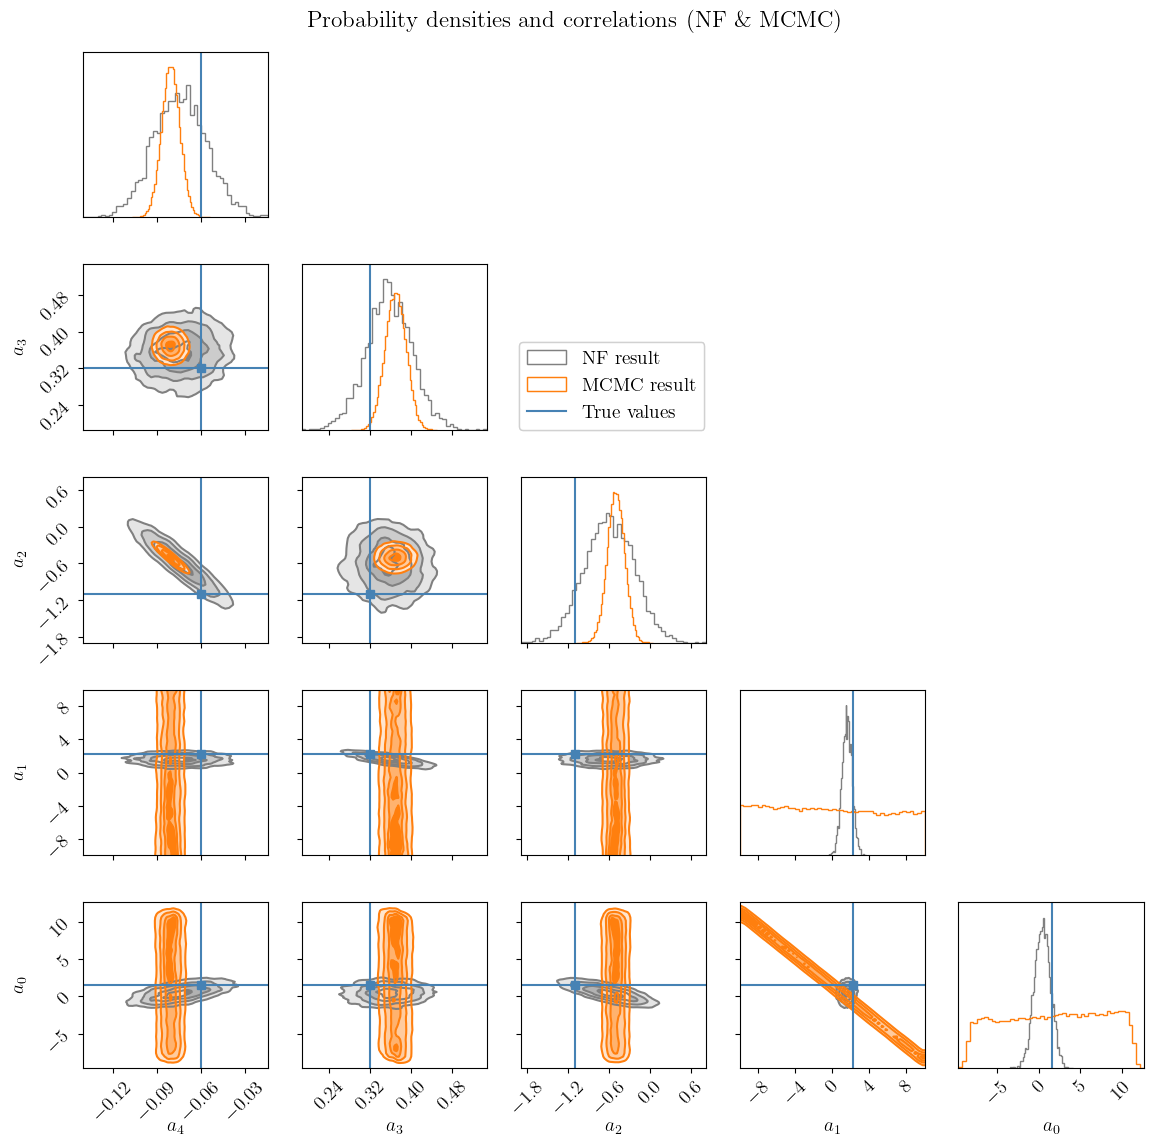

In [50]:
# Make corner plot
figure = corner.corner(x_probe_nf, labels=labels, show_titles=False, color='Gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_nf)
_ = corner.corner(x_probe_mcmc, labels=labels, truths=probeval, show_titles=False, color='C1', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_mcmc, fig=figure)
plt.suptitle('Probability densities and correlations (NF \& MCMC)')
legend = plt.legend(['NF result', 'MCMC result', 'True values'], loc='upper right', bbox_to_anchor=(-1.32, 4.44), handlelength=2.0)
plt.gca().add_artist(legend)
plt.tight_layout()
plt.savefig('nf-polynomial-regression-example-corner-nf-mcmc.pdf')